# MAP433 — Exploration Numérique 3 — Groupe BZ


**Membres**  

- KAMDEM POUOKAM Ivann Harold — **PC10**  

-  — **PC**  

-  — **PC**  


## Part 1 - Toy Dataset

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

### Q1.a

In [2]:
k = 2
mu0 = np.zeros((k,))
cov0 = np.eye(k, k)
print("mu0 =", mu0, "cov0 =", cov0, sep='\n')
sample0 = np.random.multivariate_normal(mu0, cov0, 200)

mu1 = np.full((k,), 2)
cov1 = np.array([[10, 5], [5, 10]])
print("mu1 =", mu1, "cov1 =", cov1, sep='\n')
sample1 = np.random.multivariate_normal(mu1, cov1, 200)

mu0 =
[0. 0.]
cov0 =
[[1. 0.]
 [0. 1.]]
mu1 =
[2 2]
cov1 =
[[10  5]
 [ 5 10]]


### Q1.b

In [3]:
# Preparation of datas
X_train = np.vstack([sample0, sample1])
y_train = np.array([0] * len(sample0) + [1] * len(sample1))

In [4]:
# Ajustement LDA

class LinearDiscriminantAnalysis:
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        ns = np.bincount(y_train)
        k = len(ns)
        n = len(y_train)

        masks = y_train[:, None] == np.arange(k) # shape: (n,k)
        self.means_ = np.array([X_train[masks[:, i]].mean(axis=0) for i in range(k)])

        self.priors_ = ns / n

        diffs = X_train - self.means_[y_train] # shape: (n, 2)
        self.covariance_ = diffs.T @ diffs / (n-k)

    def predict(self, X_test):
        # law = sps.multivariate_normal(self.means_[0], self.covariance_)
        # print("***", X_test.shape)
        # print("***", law.pdf(X_test))
        return np.argmax(self.priors_[:, None] * np.array([sps.multivariate_normal(mu, self.covariance_).pdf(X_test) for mu in self.means_]), axis=0)

    def predic_proba(self, X_test):
        likelihoods = self.priors_[:, None] * np.array([sps.multivariate_normal(mu, self.covariance_).pdf(X_test) for mu in self.means_])
        return likelihoods / likelihoods.sum(axis=0)
    
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print("Means of classes:\n", lda.means_)
print("Covariance matrix:\n", lda.covariance_)
print("Proportions:\n", lda.priors_)

Means of classes:
 [[ 0.05350032 -0.09860824]
 [ 1.98337548  1.85485486]]
Covariance matrix:
 [[4.07667788 1.974162  ]
 [1.974162   5.22873235]]
Proportions:
 [0.5 0.5]


In [5]:
# Ajustement QDA
qda =  QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

print("Means of classes:\n", qda.means_)
print("Covariances matrixes=:\n", qda.covariance_)
print("Proportions:\n", qda.priors_)

Means of classes:
 [[ 0.05350032 -0.09860824]
 [ 1.98337548  1.85485486]]
Covariances matrixes=:
 [array([[ 1.00421797, -0.10011596],
       [-0.10011596,  0.89592215]]), array([[7.14913778, 4.04843996],
       [4.04843996, 9.56154255]])]
Proportions:
 [0.5 0.5]


### Q1.c Visualisation of descision boundary

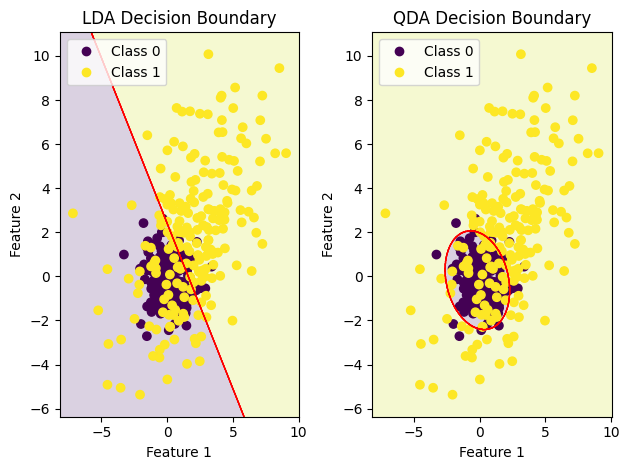

In [6]:
def plot_dec_bound(model, X, y, title="Decision boundary", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)

    h = 0.02 # grid step
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    values = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(values)
    predictions = predictions.reshape(xx.shape)

    ax.contourf(xx, yy, predictions, alpha=0.2)
    ax.contour(xx, yy, predictions, colors='red', linewidths=0.8, alpha=0.8)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    handles, labels = scatter.legend_elements()
    ax.legend(handles, [f'Class {k}' for k in range(len(labels))])

_, (ax1, ax2) = plt.subplots(1, 2)

plot_dec_bound(lda, X_train, y_train, "LDA Decision Boundary", ax1) 
plot_dec_bound(qda, X_train, y_train, "QDA Decision Boundary", ax2)
plt.tight_layout()

**Comparaison des Formes :**

L'observation directe du graphique montre deux frontières de décision de nature très différente :
* **LDA** : La frontière est une **ligne droite** (une frontière linéaire).
* **QDA** : La frontière est une **courbe** qui s'apparente à une ellipse (une frontière quadratique).

---
**Interprétation Mathématique des Différences :**

Cette différence de forme provient directement des **hypothèses mathématiques** de chaque modèle.

Les deux classifieurs cherchent à trouver la frontière où les probabilités *a posteriori* des deux classes sont égales. En supposant des distributions gaussiennes $\mathcal{N}(x | \mu_k, \Sigma_k)$ pour chaque classe $k$, la frontière est définie par l'égalité des **fonctions de score (discriminantes)** $\delta_k(x) = \delta_l(x)$.

La fonction de score (en ignorant les constantes) est :
$$\delta_k(x) = -\frac{1}{2} \log(|\Sigma_k|) - \frac{1}{2} (x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) + \log(\pi_k)$$

1.  **Pour la LDA (Analyse Discriminante Linéaire)** :
    * **Hypothèse** : La LDA suppose que toutes les classes ont la **même matrice de covariance** ($\Sigma_k = \Sigma_l = \Sigma$).
    * **Justification** : En développant le terme $(x - \mu_k)^T \Sigma^{-1} (x - \mu_k)$, on obtient $x^T \Sigma^{-1} x - 2x^T \Sigma^{-1} \mu_k + ...$.
    * Lors de l'égalité $\delta_k(x) = \delta_l(x)$, les termes $\log(|\Sigma|)$ et $x^T \Sigma^{-1} x$ sont identiques des deux côtés et **s'annulent**. L'équation de la frontière se simplifie en une équation **linéaire** en $x$ (une droite).

2.  **Pour la QDA (Analyse Discriminante Quadratique)** :
    * **Hypothèse** : La QDA suppose que chaque classe $k$ a sa **propre matrice de covariance** ($\Sigma_k \neq \Sigma_l$).
    * **Justification** : Les termes $\log(|\Sigma_k|)$ et $\log(|\Sigma_l|)$ sont différents. Plus important, les termes quadratiques $x^T \Sigma_k^{-1} x$ et $x^T \Sigma_l^{-1} x$ sont différents et **ne s'annulent pas**.
    * L'équation de la frontière ($\delta_k(x) = \delta_l(x)$) conserve donc des termes en $x^T A x$ (où $A = \Sigma_k^{-1} - \Sigma_l^{-1}$), ce qui définit une **frontière quadratique** (ici, une ellipse).

### Q1.d : Analyse et Interprétation

**Lequel des deux modèles semble le plus adapté ?**

Le modèle **QDA (Analyse Discriminante Quadratique)** est clairement le plus adapté à ce jeu de données.

**Pourquoi ? (Hypothèses des modèles)**

Pour répondre, il faut confronter les hypothèses fondamentales de chaque modèle aux données que nous avons *nous-mêmes* générées en Q1.a.

1.  **Analyse Discriminante Linéaire (LDA)** :
    * **Hypothèse Clé** : La LDA suppose que toutes les classes partagent la **même matrice de covariance** ($\Sigma_k = \Sigma$). Les nuages de points de chaque classe ont la même forme et orientation (des ellipses identiques, juste décalées).
    * **Conséquence** : Cette hypothèse forte conduit à une frontière de décision **linéaire** (une droite ou un hyperplan).

2.  **Analyse Discriminante Quadratique (QDA)** :
    * **Hypothèse Clé** : La QDA est plus flexible. Elle suppose que chaque classe $k$ possède sa **propre matrice de covariance** ($\Sigma_k$).
    * **Conséquence** : Cela permet à chaque classe d'avoir une forme et une orientation différentes, et conduit à une frontière de décision **quadratique** (une conique : ellipse, parabole ou hyperbole).

**Confrontation aux données :**

* En Q1.a, nous avons généré :
    * **Classe 0** avec $\Sigma_0 = I_2 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$ (un nuage de points circulaire).
    * **Classe 1** avec $\Sigma_1 = \begin{pmatrix} 10 & 5 \\ 5 & 10 \end{pmatrix}$ (un nuage de points elliptique, large et incliné).
* **Conclusion** : Les covariances réelles des données sont **fondamentalement différentes**. L'hypothèse de la LDA ($\Sigma_0 = \Sigma_1$) est violée. L'hypothèse de la QDA ($\Sigma_0 \neq \Sigma_1$) correspond parfaitement à la réalité des données.

## Part 2 - Classification on MNIST

### Q2.a

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_predict#, cross_validate
from sklearn.metrics import accuracy_score, recall_score, classification_report#, confusion_matrix

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X = torch.cat([train_data.data, test_data.data]).float() / 255.0
y = torch.cat([train_data.targets, test_data.targets])
y_binary = (y % 2 != 0).long()  # 0=even, 1=odd

Dataset size: 70000 images
Dimension of images: torch.Size([28, 28])
Distribution of binary classes:
  Even (0): 34418 images
  Odd (1): 35582 images


<Figure size 640x480 with 0 Axes>

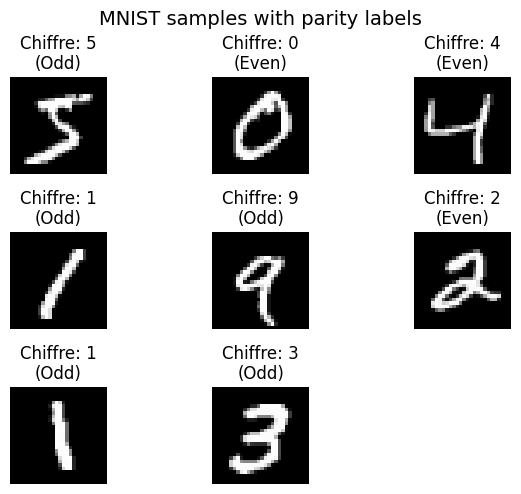

In [8]:
# Visualisation of some images of MNIST with labels
def visualise(X, y, n_samples=8, n_cols=3, title="Digits visualisation"):
    """ Display n_samples images of X with their labels in y in a grid of n_cols columns"""
    plt.figure()
    n_rows = int(np.ceil(n_samples / n_cols))
    _, axis = plt.subplots(n_rows, n_cols)
    axis = axis.ravel()

    for i in range(n_samples):
        image = X[i]
        axis[i].imshow(image, cmap='gray')

        if y is not None:
            parity = "Odd" if y[i] & 1 else "Even"
            axis[i].set_title(f'Chiffre: {y[i]}\n({parity})')
            
        axis[i].axis('off')

    # We hide unused axis
    for i in range(n_samples, len(axis)):
        axis[i].set_visible(False)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=14)

visualise(X, y, title="MNIST samples with parity labels")

# Stats
n = len(X)
print(f"Dataset size: {n} images")
print(f"Dimension of images: {X.shape[1:]}") 
print(f"Distribution of binary classes:")
n0, n1 = np.bincount(y_binary)
print(f"  Even (0): {n0} images")
print(f"  Odd (1): {n1} images")

### Q2.b

In [9]:
X_flat = X.reshape(n, -1)
pca = PCA(2)
pca.fit(X_flat)

X_pca = pca.transform(X_flat)
print(f"X_pca.shape: {X_pca.shape}")
print("Explained vars:", pca.explained_variance_)

X_pca.shape: (70000, 2)
Explained vars: [5.14100831 3.77444721]


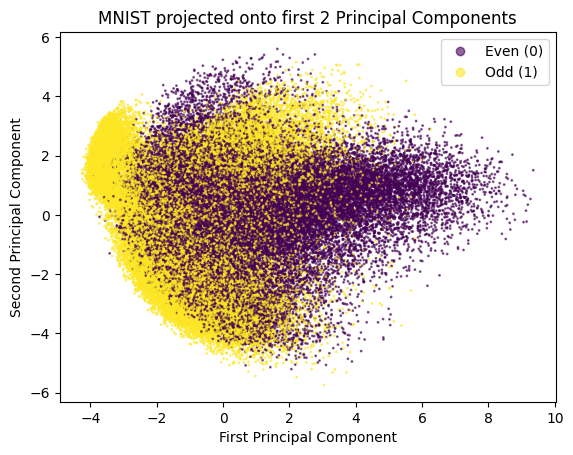

In [10]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary.numpy(), alpha=0.6, s=1)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('MNIST projected onto first 2 Principal Components')

handles, labels = scatter.legend_elements()
plt.legend(handles, ['Even (0)', 'Odd (1)'])

### Q2.c

In [11]:
lda = LinearDiscriminantAnalysis()

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
# scoring_metrics = ['accuracy', 'recall_macro'] # recall_macro, since no class is preponderant on the other
# scores = cross_validate(lda, X_pca, y_binary, cv=cv_strategy, scoring=scoring_metrics)
# print(f"Scores: {scores}")

# mean_accuracy = np.mean(scores['test_accuracy'])
# std_accuracy = np.std(scores['test_accuracy'])
# mean_recall = np.mean(scores['test_recall_macro'])
# std_recall = np.std(scores['test_recall_macro'])

# print(f"Mean accuracy: {mean_accuracy:4f} (+/- {std_accuracy:4f})")
# print(f"Mean recall: {mean_recall:4f} (+/- {std_recall:4f})")

y_pred = cross_val_predict(lda, X_pca, y_binary, cv=cv_strategy)

accuracy = accuracy_score(y_binary, y_pred)
recall_macro = recall_score(y_binary, y_pred, average='macro') # We take the average of recalls, since classes are equivalent

print(f"Accuracy: {accuracy:3f}")
print(f"Recall_macro: {recall_macro:3f}")
print(classification_report(y_binary, y_pred))

Accuracy: 0.652186
Recall_macro: 0.651216
              precision    recall  f1-score   support

           0       0.66      0.59      0.63     34418
           1       0.64      0.71      0.67     35582

    accuracy                           0.65     70000
   macro avg       0.65      0.65      0.65     70000
weighted avg       0.65      0.65      0.65     70000



### Q2.d

Nber of well-classified images: 45653
Nber of misclassified images: 24347


<Figure size 640x480 with 0 Axes>

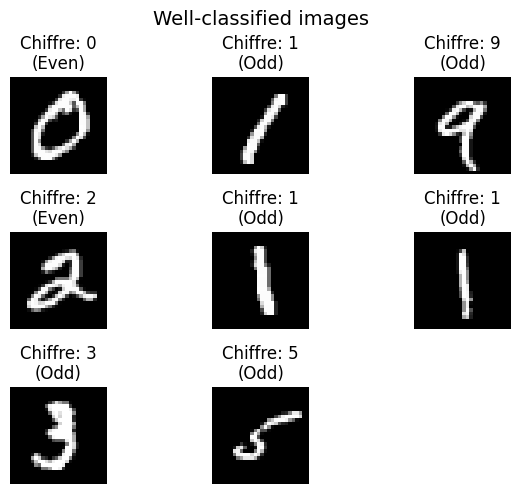

<Figure size 640x480 with 0 Axes>

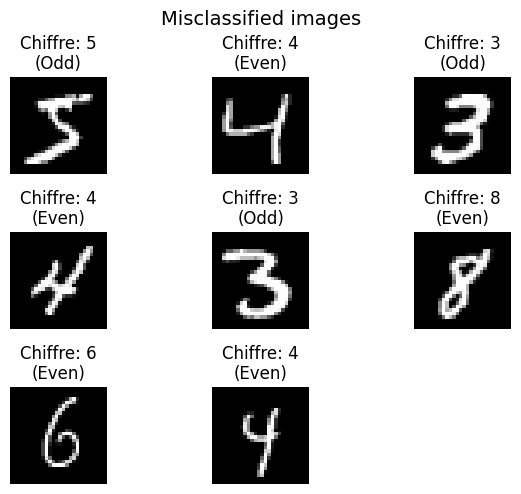

In [12]:
mask = y_binary == y_pred
X_good = X[mask]
y_good = y[mask]
X_bad = X[~mask]
y_bad = y[~mask]

print(f"Nber of well-classified images: {len(y_good)}")
print(f"Nber of misclassified images: {len(y_bad)}")

visualise(X_good, y_good, title="Well-classified images")
visualise(X_bad, y_bad, title="Misclassified images")

### Q2.e 

In [13]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Linear(32*7*7, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        h = self.fc[0:2](x)  # penultimate activations
        out = self.fc[2](h)
        return out, h

model = SmallCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dataset = TensorDataset(X.unsqueeze(1), y_binary.float())
loader = DataLoader(dataset, batch_size=128, shuffle=True)

n_epochs = 5
model.train()

for epoch in range(n_epochs):
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        out, _ = model(xb)
        train_loss = loss_fn(out.squeeze(), yb)
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        
    print(f"Epoch {epoch+1}, loss={train_loss.item():.4f}")

Epoch 1, loss=0.1001
Epoch 2, loss=0.0730
Epoch 3, loss=0.0453
Epoch 4, loss=0.0112
Epoch 5, loss=0.0699


### Q2.f

In [14]:
# We extract the features
model.eval()
X_ = []
X_new = []
y_new = []

with torch.no_grad(): # We no more need to compute gradients
    for images, labels in loader:
        _, h = model(images) # We deal only with the penultimate activations
        X_.extend(images)
        X_new.extend(h)
        y_new.extend(labels)

X_ = np.array(X_).squeeze()
X_new = np.array(X_new)
y_new = np.array(y_new, dtype=np.int32)

# We retrain LDA on the new features
y_pred = cross_val_predict(lda, X_new, y_new, cv=cv_strategy)

print(classification_report(y_new, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     34418
           1       0.99      0.99      0.99     35582

    accuracy                           0.99     70000
   macro avg       0.99      0.99      0.99     70000
weighted avg       0.99      0.99      0.99     70000



Nber of misclassified images: 729


<Figure size 640x480 with 0 Axes>

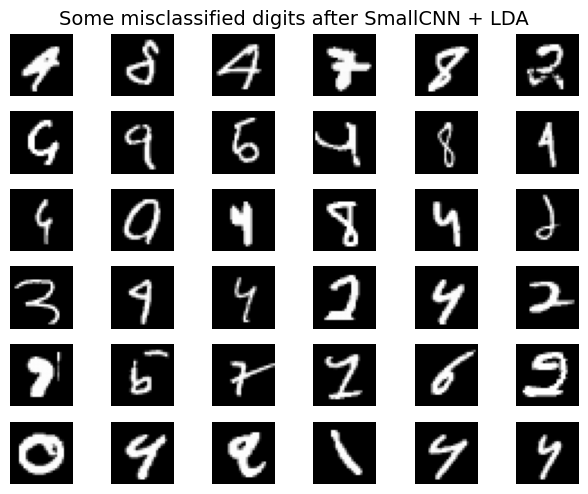

In [15]:
# We visualise some misclassified images
mask = y_pred != y_new
X_bad2 = X_[mask]

print("Nber of misclassified images:", len(X_bad2))

visualise(X_bad2, None, n_samples=36, n_cols=6, title="Some misclassified digits after SmallCNN + LDA")

### Q2.g

In [16]:
# We compute the Principal Components Analysis
pca.fit(X_new)

X_pca2 = pca.transform(X_new)

print(f"X_pca2.shape: {X_pca2.shape}")
print("Explained vars:", pca.explained_variance_)

X_pca2.shape: (70000, 2)
Explained vars: [65.460526  7.859383]


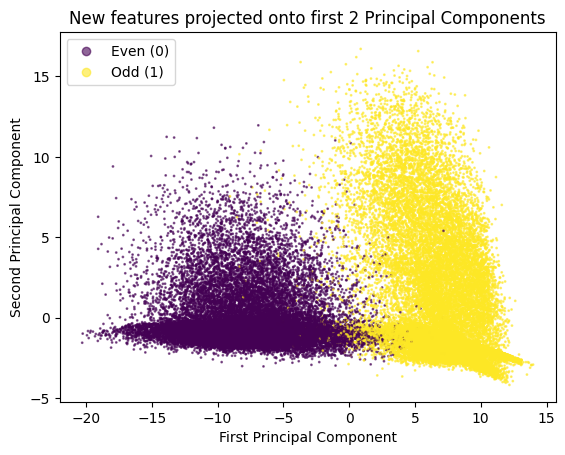

In [17]:
# We visualise the result
scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_new, alpha=0.6, s=1)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('New features projected onto first 2 Principal Components')

handles, labels = scatter.legend_elements()
plt.legend(handles, ['Even (0)', 'Odd (1)'])

### Q2.g : Analyse et Interprétation

**Commentaire sur les résultats :**

L'impact de l'extraction de caractéristiques par le CNN est spectaculaire. Les métriques de performance (Accuracy, Recall, ...) ont bondi, passant d'environ **65 %** pour la LDA sur l'ACP des pixels bruts, à **99 %** pour la LDA sur les caractéristiques du CNN.

1.  **Pourquoi les modèles linéaires sont-ils limités sur les pixels bruts ?**
    * **Haute dimensionnalité et non-linéarité** : Une image brute de 28x28 possède 784 caractéristiques (pixels). La parité d'un chiffre est un concept abstrait qui dépend de relations *non-linéaires* complexes entre ces pixels.
    * **Faible séparabilité** : Comme le montre le premier graphique ACP, les classes "Pair" (0) et "Impair" (1) se superposent massivement dans l'espace des pixels. Il n'existe pas d'hyperplan simple (une droite dans l'espace 2D de l'ACP) capable de les séparer efficacement. La LDA, étant un modèle linéaire, échoue logiquement.

2.  **Pourquoi les caractéristiques du CNN permettent-elles une meilleure séparabilité ?**
    * **Apprentissage de représentation** : Le `SmallCNN` agit comme un **extracteur de caractéristiques** sophistiqué. Il a été entraîné spécifiquement pour la tâche de classification de parité.
    * **Transformation non-linéaire** : Ses couches de convolution et d'activation ont appris à transformer l'espace d'origine (784D) en un nouvel espace de caractéristiques (64D).
    * **Séparabilité linéaire** : La clé est que ce nouvel espace de 64D a été **optimisé pour rendre la tâche facile**. Les caractéristiques extraites sont conçues pour que les chiffres pairs et impairs deviennent **linéairement séparables**.
    * **Preuve visuelle** : Le second graphique ACP le démontre parfaitement. En projetant l'espace 64D du CNN sur ses deux composantes principales, nous voyons deux nuages de points distincts, permettant à un simple classifieur linéaire comme la LDA de trouver une frontière quasi parfaite.